# Ploting sky map

In [ ]:
# # get the data 
! wget 'https://dcc.ligo.org/public/0146/G1701985/001/bayestar_no_virgo.fits.gz'
# unzip
! gunzip bayestar_no_virgo.fits.gz -y

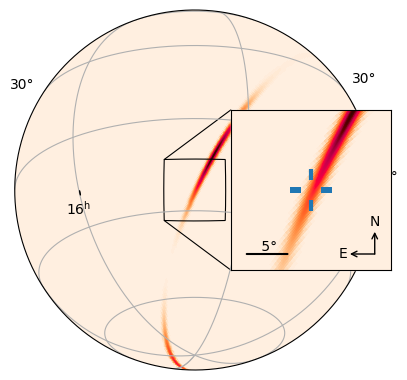

In [5]:
# An example from https://lscsoft.docs.ligo.org/ligo.skymap/plot/allsky.html

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
import ligo.skymap.plot
from matplotlib import pyplot as plt
import numpy as np

url = 'bayestar_no_virgo.fits'
center = SkyCoord.from_name('NGC 4993')

fig = plt.figure(figsize=(4, 4), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=10*u.deg)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')
ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset.compass(0.9, 0.1, 0.2)

ax.imshow_hpx(url, cmap='cylon')
ax_inset.imshow_hpx(url, cmap='cylon')
ax_inset.plot(
    center.ra.deg, center.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=30,
    markeredgewidth=3)

In [21]:
# looking at the contents of the data
# import bayestar_no_virgo.fits
import healpy as hp
from astropy.io import fits
import numpy as np

filename = 'bayestar_no_virgo.fits'
hdulist = fits.open(filename)
hdulist.info()

Filename: bayestar_no_virgo.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     55   12582912R x 4C   [D, D, D, D]   


In [22]:
data = hdulist[1].data
data.columns

ColDefs(
    name = 'PROB'; format = 'D'; unit = 'pix-1'
    name = 'DISTMU'; format = 'D'; unit = 'Mpc'
    name = 'DISTSIGMA'; format = 'D'; unit = 'Mpc'
    name = 'DISTNORM'; format = 'D'; unit = 'Mpc-2'
)

## Getting data at the right format 

* ligo.skymap uses fits files

* get a random event as an example

In [54]:
from lal import CreateREAL8FrequencySeries
from lalsimulation import SimNoisePSD, SimNoisePSDaLIGOZeroDetHighPowerPtr
from ligo.skymap.io.events import Event, SingleEvent
import numpy as np

class RandomEvent(Event):

    def __init__(self):
        self._singles = [RandomSingleEvent('H1'), RandomSingleEvent('L1')]
        self._template_args = {'mass1': np.random.uniform(1.0, 3.0),
                               'mass2': np.random.uniform(1.0, 3.0)}

    @property
    def singles(self):
        return self._singles

    @property
    def template_args(self):
        return self._template_args


class RandomSingleEvent(SingleEvent):

    def __init__(self, detector):
        self._detector = detector
        self._snr = np.random.uniform(1, 10)
        self._phase = np.random.uniform(-np.pi, np.pi)
        self._time = np.random.uniform(1e9, 1.1e9)
        self._psd = CreateREAL8FrequencySeries(name=None, epoch=None, f0=0.0,
                                               deltaF=1.0, sampleUnits=None,
                                               length=16384)
        SimNoisePSD(psd=self._psd, flow=10.0,
                    psdfunc=SimNoisePSDaLIGOZeroDetHighPowerPtr)
        self._psd.data.data[self._psd.data.data == 0] = np.inf

    @property
    def detector(self):
        return self._detector

    @property
    def snr(self):
        return self._snr

    @property
    def phase(self):
        return self._phase

    @property
    def time(self):
        return self._time

    @property
    def zerolag_time(self):
        return self._time

    @property
    def psd(self):
        return self._psd


np.random.seed(0)
event = RandomEvent()
print(event)

<RandomEvent(singles=[<RandomSingleEvent(detector='H1', snr=5.939321535345923, phase=1.352074665052471, time=1060276337.6071644)>, <RandomSingleEvent(detector='L1', snr=5.903948646972072, phase=-0.4796910430674712, time=1064589411.3066657)>])>


In [55]:
bys = RandomEvent()

In [56]:
from ligo.skymap import bayestar
test = bayestar.localize(event=bys)
test.keys()

Truncating PSD at 0.95 of maximum frequency to suppress rolloff artifacts. This option may be removed in the future.
Truncating PSD at 0.95 of maximum frequency to suppress rolloff artifacts. This option may be removed in the future.
Template is unspecified; using ER10/O2 uberbank criterion
Assuming PSD is infinite at 0.0078125 Hz because PSD is only sampled down to 1 Hz
Assuming PSD is infinite at 0.0078125 Hz because PSD is only sampled down to 1 Hz
No SNR time series found, so we are creating a zero-noise SNR time series from the whitened template's autocorrelation sequence. The sky localization uncertainty may be underestimated.


['UNIQ', 'PROBDENSITY', 'DISTMU', 'DISTSIGMA', 'DISTNORM']

In [60]:
import ligo.skymap as ls
fits_test = ls.io.fits.write_sky_map('test.fits',test)

In [61]:
filename = 'test.fits'
hdulist = fits.open(filename)
hdulist.info()

Filename: test.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     50   19200R x 5C   [K, D, D, D, D]   


In [62]:
data = hdulist[1].data
data.columns

ColDefs(
    name = 'UNIQ'; format = 'K'
    name = 'PROBDENSITY'; format = 'D'; unit = 'sr-1'
    name = 'DISTMU'; format = 'D'; unit = 'Mpc'
    name = 'DISTSIGMA'; format = 'D'; unit = 'Mpc'
    name = 'DISTNORM'; format = 'D'; unit = 'Mpc-2'
)

ValueError: nside must be a power of two

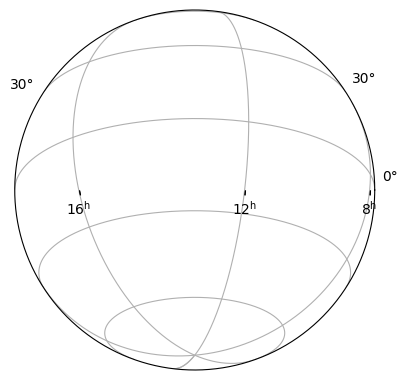

In [63]:
url = 'test.fits'

fig = plt.figure(figsize=(4, 4), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()

ax.imshow_hpx(url, cmap='cylon')
ax_inset.imshow_hpx(url, cmap='cylon')
ax_inset.plot(
    center.ra.deg, center.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=30,
    markeredgewidth=3)

In [71]:
# this the replication of the function where error arises
# the value should be True
nside = np.sqrt(len(test) / 12)
log_2_nside = np.round(np.log2(nside))
2 ** log_2_nside == nside

False

### Let's tackle problem by changing data length

In [64]:
len(test['UNIQ'])

19200

* change the length of the data to 12*(2**number)**2

* 12*(2**5)**2 = 12*32**2 = 12*1024 = 12288

In [65]:
type(test)

astropy.table.table.Table

In [66]:
# test is a astropy.table.table.Table
# change test's data length to 12288
from astropy.table import Table, Column
import numpy as np

# Assuming 'test' is your existing Table
desired_length = 12288

# Create a new table to store the modified columns
new_table = Table()

for col_name in test.colnames:
    column_data = test[col_name]
    current_length = len(column_data)

    if current_length > desired_length:
        # If the current length is greater, truncate the data
        new_data = column_data[:desired_length]
    elif current_length < desired_length:
        # If the current length is less, pad the data
        if np.issubdtype(column_data.dtype, np.number):
            pad_value = np.nan  # Use np.nan for numerical data
        else:
            pad_value = ''  # Use an empty string for other types of data

        # Prepare padding
        padding = np.full(desired_length - current_length, pad_value, dtype=column_data.dtype)
        new_data = np.concatenate([column_data, padding])
    else:
        # If the length matches, use the data as is
        new_data = column_data

    # Add the modified column to the new table
    new_table[col_name] = new_data

# 'new_table' now has each column adjusted to the desired length of 12288



In [67]:
len(new_table['UNIQ'])

12288

In [68]:
import ligo.skymap as ls
fits_test = ls.io.fits.write_sky_map('test2.fits',new_table)

In [70]:
# this the replication of the function where error arises
# the value should be True
nside = np.sqrt(len(new_table) / 12)
log_2_nside = np.round(np.log2(nside))
2 ** log_2_nside == nside

True

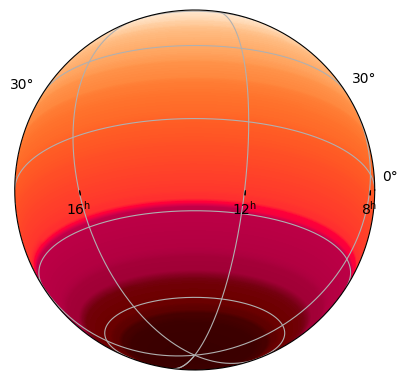

In [75]:
url = 'test2.fits'

fig = plt.figure(figsize=(4, 4), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()

ax.imshow_hpx(url, cmap='cylon')
ax_inset.imshow_hpx(url, cmap='cylon')
ax_inset.plot(
    center.ra.deg, center.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=30,
    markeredgewidth=3)

* I don't know whether this is right. ???